In [7]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import holidays
# 加载训练数据
#数据预处理
order_train = pd.read_csv('data/order_train2.csv')
# 将订单数据中的日期从字符串类型转换为日期类型
order_train['order_date'] = pd.to_datetime(order_train['order_date'])
# order_train = order_train[(order_train['order_date'].dt.year == 2018) & (order_train['order_date'].dt.month >=7) ]
order_train['is_holiday'] = order_train['order_date'].isin(holidays.China(years=[2015,2016,2017,2018]))
order_train['is_holiday'] = order_train['is_holiday'].astype(int)
order_train['year'] = order_train['order_date'].dt.year
order_train['month'] = order_train['order_date'].dt.month
order_train['day'] = order_train['order_date'].dt.day
order_train['weekday'] = order_train['order_date'].dt.weekday
order_train['week'] = order_train['order_date'].dt.isocalendar().week.astype('int64')
order_train["season"] = ((order_train["order_date"].dt.month-1)//3+1)

order_train = order_train[order_train['ord_qty'] < order_train['ord_qty'].quantile(0.99)]  # 清除需求量极大异常值
order_train['sales_chan_name'] = order_train['sales_chan_name'].replace({'online': 0, 'offline': 1})

predict_df = pd.read_csv('data/predict_sku1.csv')
print(order_train)

       order_date  sales_region_code  item_code  first_cate_code  \
0      2015-09-01                104      22069              307   
1      2015-09-01                104      20028              301   
2      2015-09-02                104      21183              307   
3      2015-09-02                104      20448              308   
4      2015-09-02                104      21565              307   
...           ...                ...        ...              ...   
597377 2018-12-20                102      20994              302   
597378 2018-12-20                102      21875              302   
597379 2018-12-20                102      20215              302   
597380 2018-12-20                102      20195              302   
597381 2018-12-20                102      20321              302   

        second_cate_code  sales_chan_name  item_price  ord_qty  is_holiday  \
0                    403                1      1114.0       19           0   
1                    405   

In [8]:
import numpy as np
code_columns=['sales_region_code', 'first_cate_code', 'second_cate_code']
for cc in code_columns:
    order_train[cc] = order_train[cc].astype('category')
order_train = pd.get_dummies(order_train, columns=code_columns, drop_first=True)

order_train['month_sin'] = np.sin((order_train['month'] - 1) * (2.0 * np.pi / 12))
order_train['month_cos'] = np.cos((order_train['month'] - 1) * (2.0 * np.pi / 12))
order_train['season_sin'] = np.sin((order_train['season'] - 1) * (2.0 * np.pi / 4))
order_train['season_cos'] = np.cos((order_train['season'] - 1) * (2.0 * np.pi / 4))
selected_features = order_train.columns.drop(['order_date', 'ord_qty','item_price','sales_chan_name','sales_region_code_104'])
print(selected_features)

Index(['item_code', 'is_holiday', 'year', 'month', 'day', 'weekday', 'week',
       'season', 'sales_region_code_102', 'sales_region_code_103',
       'sales_region_code_105', 'first_cate_code_302', 'first_cate_code_303',
       'first_cate_code_304', 'first_cate_code_305', 'first_cate_code_306',
       'first_cate_code_307', 'first_cate_code_308', 'second_cate_code_402',
       'second_cate_code_403', 'second_cate_code_404', 'second_cate_code_405',
       'second_cate_code_406', 'second_cate_code_407', 'second_cate_code_408',
       'second_cate_code_409', 'second_cate_code_410', 'second_cate_code_411',
       'second_cate_code_412', 'month_sin', 'month_cos', 'season_sin',
       'season_cos'],
      dtype='object')


In [10]:
# 训练集和验证集的划分
X_train, X_val, y_train, y_val = train_test_split(order_train[selected_features], order_train['ord_qty'], test_size=0.2, random_state=42)
print(len(X_train))

473118


In [ ]:
from sklearn.model_selection import GridSearchCV
# 网格搜索
param_grid = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 6, 9],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0.01, 0.1, 1]
}
xgb = XGBRegressor()
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# 交叉验证的结果
print("最优参数：", grid_search.best_params_)
print("最优得分：", np.sqrt(-grid_search.best_score_))

In [16]:
# 定义回调函数
def log_progress(booster, eval_set):
    results = list()
    for i, metric in enumerate(eval_set):
        results.append((metric[0], metric[1], 'validation'))
    return dict(results)

# XGBoost模型
xgb = XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=9, subsample=0.8, colsample_bytree=0.8, gamma=1)
# eval_set = [(X_train, y_train), (X_val, y_val)]
# eval_metric = ["rmse"]
# results = {}
# 模型训练
xgb.fit(X_train, y_train, eval_metric='rmse', early_stopping_rounds=10, eval_set=[(X_val, y_val)])



[0]	validation_0-rmse:143.38784
[1]	validation_0-rmse:141.02186
[2]	validation_0-rmse:138.94397
[3]	validation_0-rmse:137.08784
[4]	validation_0-rmse:135.19566
[5]	validation_0-rmse:133.57945
[6]	validation_0-rmse:132.23174
[7]	validation_0-rmse:130.85377
[8]	validation_0-rmse:129.59824
[9]	validation_0-rmse:128.37325
[10]	validation_0-rmse:127.39475
[11]	validation_0-rmse:126.31146
[12]	validation_0-rmse:125.41124
[13]	validation_0-rmse:124.62188
[14]	validation_0-rmse:123.72623
[15]	validation_0-rmse:123.09621
[16]	validation_0-rmse:122.44286
[17]	validation_0-rmse:121.84472
[18]	validation_0-rmse:121.25882
[19]	validation_0-rmse:120.82232
[20]	validation_0-rmse:120.37547
[21]	validation_0-rmse:119.91835
[22]	validation_0-rmse:119.38811
[23]	validation_0-rmse:119.05828
[24]	validation_0-rmse:118.62174
[25]	validation_0-rmse:118.30215
[26]	validation_0-rmse:118.01150
[27]	validation_0-rmse:117.72244
[28]	validation_0-rmse:117.43932
[29]	validation_0-rmse:117.25980
[30]	validation_0-rm

[245]	validation_0-rmse:109.98793
[246]	validation_0-rmse:109.98462
[247]	validation_0-rmse:109.97946
[248]	validation_0-rmse:109.97344
[249]	validation_0-rmse:109.96177
[250]	validation_0-rmse:109.95563
[251]	validation_0-rmse:109.95168
[252]	validation_0-rmse:109.95021
[253]	validation_0-rmse:109.93910
[254]	validation_0-rmse:109.93322
[255]	validation_0-rmse:109.92335
[256]	validation_0-rmse:109.91575
[257]	validation_0-rmse:109.91139
[258]	validation_0-rmse:109.90153
[259]	validation_0-rmse:109.89822
[260]	validation_0-rmse:109.88946
[261]	validation_0-rmse:109.88700
[262]	validation_0-rmse:109.88304
[263]	validation_0-rmse:109.86928
[264]	validation_0-rmse:109.86697
[265]	validation_0-rmse:109.86369
[266]	validation_0-rmse:109.85089
[267]	validation_0-rmse:109.84255
[268]	validation_0-rmse:109.82192
[269]	validation_0-rmse:109.81087
[270]	validation_0-rmse:109.80972
[271]	validation_0-rmse:109.79076
[272]	validation_0-rmse:109.77812
[273]	validation_0-rmse:109.77452
[274]	validati

[486]	validation_0-rmse:108.78660
[487]	validation_0-rmse:108.78317
[488]	validation_0-rmse:108.78197
[489]	validation_0-rmse:108.77901
[490]	validation_0-rmse:108.77759
[491]	validation_0-rmse:108.77706
[492]	validation_0-rmse:108.77656
[493]	validation_0-rmse:108.77400
[494]	validation_0-rmse:108.77133
[495]	validation_0-rmse:108.76824
[496]	validation_0-rmse:108.76661
[497]	validation_0-rmse:108.76577
[498]	validation_0-rmse:108.76607
[499]	validation_0-rmse:108.76504
[500]	validation_0-rmse:108.76463
[501]	validation_0-rmse:108.76271
[502]	validation_0-rmse:108.76180
[503]	validation_0-rmse:108.75979
[504]	validation_0-rmse:108.75689
[505]	validation_0-rmse:108.75815
[506]	validation_0-rmse:108.75248
[507]	validation_0-rmse:108.75178
[508]	validation_0-rmse:108.74606
[509]	validation_0-rmse:108.74471
[510]	validation_0-rmse:108.74156
[511]	validation_0-rmse:108.73867
[512]	validation_0-rmse:108.73826
[513]	validation_0-rmse:108.73216
[514]	validation_0-rmse:108.72886
[515]	validati

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=1, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

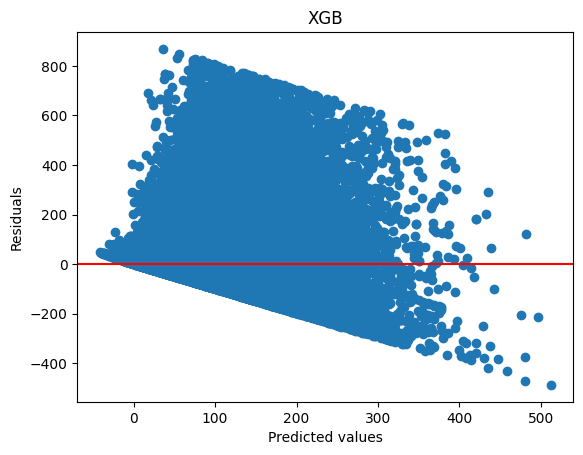

In [19]:
import matplotlib.pyplot as plt
import numpy as np
y_pred = xgb.predict(X_val)

# 计算残差
residuals = y_val - y_pred

# 绘制残差图
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('XGB')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()


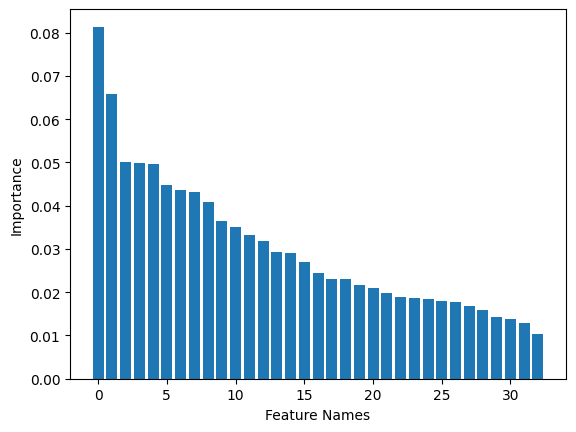

In [113]:
import numpy as np

# 获取特征重要性
importance = xgb.feature_importances_

# 获取特征名称
feat_names = xgb.get_booster().feature_names

# 将特征名称和特征重要性排序
sorted_idx = importance.argsort()[::-1]

# 将特征重要性和特征名称进行可视化
plt.bar(np.arange(len(feat_names)), importance[sorted_idx])

plt.xlabel('Feature Names')
plt.ylabel('Importance')
plt.show()

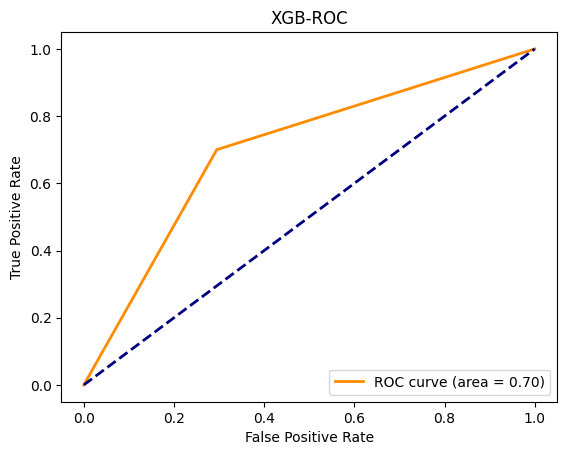

In [33]:
from sklearn.metrics import roc_curve, auc
# 预测概率
y_score = xgb.predict(X_val)

# 计算ROC曲线
fpr, tpr, thresholds = roc_curve(np.where(y_val >= np.median(y_val), 1, 0), np.where(y_pred >= np.median(y_pred), 1, 0))
roc_auc = auc(fpr, tpr)

# 绘制ROC曲线
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGB-ROC')
plt.legend(loc="lower right")
plt.show()

In [89]:
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from sklearn.metrics import accuracy_score
# 预测
y_pred = xgb.predict(X_val)
print(len(y_pred))
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)

# 计算均方误差（MSE）、均方根误差（RMSE）、平均绝对误差（MAE）
# print(model.score(X_train, y_train))
# print(model.score(X_test, y_test))
print('MSE:', mse)
print('RMSE:',rmse )
print('MAE:', mae)
print('R2:',r2 )

# MSE: 6716.721613255811
# RMSE: 81.95560757663755
# MAE: 46.7511664280517
# R2: 0.26882267803800275

118280
MSE: 11186.266425527829
RMSE: 105.7651474992014
MAE: 61.814737081387655
R2: 0.26917349235479904


In [ ]:
# 绘制差异图
x_values = np.arange(len(y_true))
plt.plot(x_values, y_true, '-o', label='True')
plt.plot(x_values, y_pred, '-o', label='Predicted')
plt.plot(x_values, y_true1, '-x', label='True1')
plt.plot(x_values, y_pred1, '-x', label='Predicted1')
plt.legend()
plt.title('Prediction vs. True Values')
plt.xlabel('Data points')
plt.ylabel('Value')
plt.show()

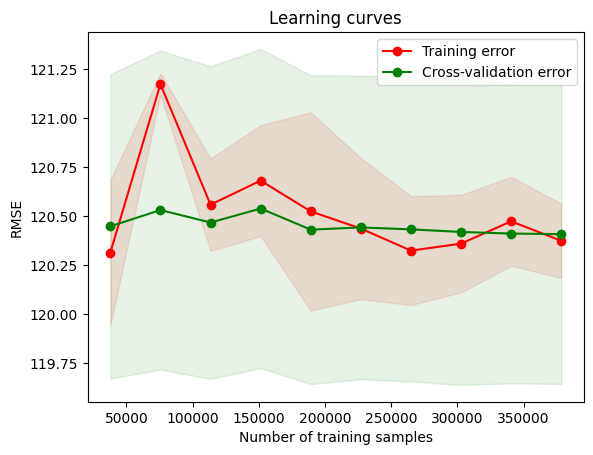

In [90]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

# 创建一个简单的线性回归模型
model = LinearRegression()

# 计算不同观测点下的训练集和验证集误差
train_sizes, train_scores, test_scores = learning_curve(
    model, X_train, y_train, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='neg_root_mean_squared_error'
)

# 计算训练集和验证集的平均误差，以及标准差
train_mean = -np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = -np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# 绘制学习曲线
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training error')
plt.plot(train_sizes, test_mean, 'o-', color='g', label='Cross-validation error')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='g')
plt.xlabel('Number of training samples')
plt.ylabel('RMSE')
plt.title('Learning curves')
plt.legend(loc='best')
plt.show()

开始预测
   sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                  1      20002           411           274           356
   sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                  1      20002           411           274           356
1                  1      20003          3407          2476          3460
   sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                  1      20002           411           274           356
1                  1      20003          3407          2476          3460
2                  1      20006          2432          2063          2481
   sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                  1      20002           411           274           356
1                  1      20003          3407          2476          3460
2                  1      20006          2432          2063          2481
3                  1      20011  

    sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                   1      20002           411           274           356
1                   1      20003          3407          2476          3460
2                   1      20006          2432          2063          2481
3                   1      20011          1020          1379          1096
4                   1      20014          7270          7522          6706
5                   1      20016          2526          2026          2550
6                   1      20018          4610          3278          4571
7                   1      20020          1139           513           699
8                   1      20021          1225           606           862
9                   1      20024          4018          1469          2372
10                  1      20039          1406          2158          2368
11                  1      20041          2871          3861          4582
12                  1    

    sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                   1      20002           411           274           356
1                   1      20003          3407          2476          3460
2                   1      20006          2432          2063          2481
3                   1      20011          1020          1379          1096
4                   1      20014          7270          7522          6706
5                   1      20016          2526          2026          2550
6                   1      20018          4610          3278          4571
7                   1      20020          1139           513           699
8                   1      20021          1225           606           862
9                   1      20024          4018          1469          2372
10                  1      20039          1406          2158          2368
11                  1      20041          2871          3861          4582
12                  1    

    sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                   1      20002           411           274           356
1                   1      20003          3407          2476          3460
2                   1      20006          2432          2063          2481
3                   1      20011          1020          1379          1096
4                   1      20014          7270          7522          6706
5                   1      20016          2526          2026          2550
6                   1      20018          4610          3278          4571
7                   1      20020          1139           513           699
8                   1      20021          1225           606           862
9                   1      20024          4018          1469          2372
10                  1      20039          1406          2158          2368
11                  1      20041          2871          3861          4582
12                  1    

    sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                   1      20002           411           274           356
1                   1      20003          3407          2476          3460
2                   1      20006          2432          2063          2481
3                   1      20011          1020          1379          1096
4                   1      20014          7270          7522          6706
5                   1      20016          2526          2026          2550
6                   1      20018          4610          3278          4571
7                   1      20020          1139           513           699
8                   1      20021          1225           606           862
9                   1      20024          4018          1469          2372
10                  1      20039          1406          2158          2368
11                  1      20041          2871          3861          4582
12                  1    

    sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                   1      20002           411           274           356
1                   1      20003          3407          2476          3460
2                   1      20006          2432          2063          2481
3                   1      20011          1020          1379          1096
4                   1      20014          7270          7522          6706
5                   1      20016          2526          2026          2550
6                   1      20018          4610          3278          4571
7                   1      20020          1139           513           699
8                   1      20021          1225           606           862
9                   1      20024          4018          1469          2372
10                  1      20039          1406          2158          2368
11                  1      20041          2871          3861          4582
12                  1    

    sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                   1      20002           411           274           356
1                   1      20003          3407          2476          3460
2                   1      20006          2432          2063          2481
3                   1      20011          1020          1379          1096
4                   1      20014          7270          7522          6706
5                   1      20016          2526          2026          2550
6                   1      20018          4610          3278          4571
7                   1      20020          1139           513           699
8                   1      20021          1225           606           862
9                   1      20024          4018          1469          2372
10                  1      20039          1406          2158          2368
11                  1      20041          2871          3861          4582
12                  1    

    sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                   1      20002           411           274           356
1                   1      20003          3407          2476          3460
2                   1      20006          2432          2063          2481
3                   1      20011          1020          1379          1096
4                   1      20014          7270          7522          6706
..                ...        ...           ...           ...           ...
60                  1      20198          1330          1076          1311
61                  1      20206          3168          2295          2499
62                  1      20215          1563          1304          1552
63                  1      20218          1548          1311          1598
64                  1      20221           986           823          1363

[65 rows x 5 columns]
    sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0 

    sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                   1      20002           411           274           356
1                   1      20003          3407          2476          3460
2                   1      20006          2432          2063          2481
3                   1      20011          1020          1379          1096
4                   1      20014          7270          7522          6706
..                ...        ...           ...           ...           ...
76                  1      20252          2397          1826          2616
77                  1      20253          6361          5748          7187
78                  1      20254           534           398           773
79                  1      20256          2428          1530          1980
80                  1      20259          2131          1709          2625

[81 rows x 5 columns]
    sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0 

    sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                   1      20002           411           274           356
1                   1      20003          3407          2476          3460
2                   1      20006          2432          2063          2481
3                   1      20011          1020          1379          1096
4                   1      20014          7270          7522          6706
..                ...        ...           ...           ...           ...
93                  1      20305          1526          1053          1017
94                  1      20311          3209          1866          1879
95                  1      20313          3239          2468          2658
96                  1      20316          1567          1123          1735
97                  1      20320          2029          1481          2426

[98 rows x 5 columns]
    sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0 

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           411           274           356
1                    1      20003          3407          2476          3460
2                    1      20006          2432          2063          2481
3                    1      20011          1020          1379          1096
4                    1      20014          7270          7522          6706
..                 ...        ...           ...           ...           ...
109                  1      20343          3847          3289          4070
110                  1      20344          5553          4941          5078
111                  1      20346          3610          2962          3612
112                  1      20347          4774          4395          4482
113                  1      20350          3385          2738          2767

[114 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           411           274           356
1                    1      20003          3407          2476          3460
2                    1      20006          2432          2063          2481
3                    1      20011          1020          1379          1096
4                    1      20014          7270          7522          6706
..                 ...        ...           ...           ...           ...
118                  1      20366          1667          1231          1396
119                  1      20368          4252          3488          4377
120                  1      20370          6443          5486          6071
121                  1      20384          3040          2041          2022
122                  1      20387          2469          1937          1952

[123 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           411           274           356
1                    1      20003          3407          2476          3460
2                    1      20006          2432          2063          2481
3                    1      20011          1020          1379          1096
4                    1      20014          7270          7522          6706
..                 ...        ...           ...           ...           ...
134                  1      20414          3726          3397          3802
135                  1      20416          1435          1260          1920
136                  1      20418          3114          2530          2919
137                  1      20419          3050          2731          3671
138                  1      20422          1043           840           987

[139 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           411           274           356
1                    1      20003          3407          2476          3460
2                    1      20006          2432          2063          2481
3                    1      20011          1020          1379          1096
4                    1      20014          7270          7522          6706
..                 ...        ...           ...           ...           ...
151                  1      20459          1378          1046          1105
152                  1      20461           263           181           229
153                  1      20465          1294          1028          1203
154                  1      20473          2397          1985          2808
155                  1      20478          2130          1679          1767

[156 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           411           274           356
1                    1      20003          3407          2476          3460
2                    1      20006          2432          2063          2481
3                    1      20011          1020          1379          1096
4                    1      20014          7270          7522          6706
..                 ...        ...           ...           ...           ...
167                  1      20512          4154          3823          4685
168                  1      20515          2731          1655          1681
169                  1      20522          1846          1316          1499
170                  1      20523          4814          4305          5031
171                  1      20525          1942          1579          2224

[172 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           411           274           356
1                    1      20003          3407          2476          3460
2                    1      20006          2432          2063          2481
3                    1      20011          1020          1379          1096
4                    1      20014          7270          7522          6706
..                 ...        ...           ...           ...           ...
183                  1      20563          1258           923           904
184                  1      20567           552           223           121
185                  1      20569          2169          1203          1120
186                  1      20575          7886          6418          7339
187                  1      20580          2093          1347          1541

[188 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           411           274           356
1                    1      20003          3407          2476          3460
2                    1      20006          2432          2063          2481
3                    1      20011          1020          1379          1096
4                    1      20014          7270          7522          6706
..                 ...        ...           ...           ...           ...
199                  1      20624          2122          1605          1785
200                  1      20625          1819          1352          1524
201                  1      20627          4078          2962          3067
202                  1      20628          2547          2067          2332
203                  1      20631          5352          3895          4330

[204 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           411           274           356
1                    1      20003          3407          2476          3460
2                    1      20006          2432          2063          2481
3                    1      20011          1020          1379          1096
4                    1      20014          7270          7522          6706
..                 ...        ...           ...           ...           ...
208                  1      20653          3639          3147          3209
209                  1      20654          1997          1302          1462
210                  1      20655          2603          1871          2548
211                  1      20656          2686          2268          2490
212                  1      20657           529           532           607

[213 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           411           274           356
1                    1      20003          3407          2476          3460
2                    1      20006          2432          2063          2481
3                    1      20011          1020          1379          1096
4                    1      20014          7270          7522          6706
..                 ...        ...           ...           ...           ...
217                  1      20666          3985          3004          3356
218                  1      20668          2591          2027          3032
219                  1      20672          2897          2165          2419
220                  1      20674          6585          5710          6589
221                  1      20675          3803          2849          3162

[222 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           411           274           356
1                    1      20003          3407          2476          3460
2                    1      20006          2432          2063          2481
3                    1      20011          1020          1379          1096
4                    1      20014          7270          7522          6706
..                 ...        ...           ...           ...           ...
234                  1      20701          3622          1753          1916
235                  1      20704          4320          2652          3035
236                  1      20707          2826          1733          2345
237                  1      20712          2974          1679          2378
238                  1      20714          3053          2009          2096

[239 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           411           274           356
1                    1      20003          3407          2476          3460
2                    1      20006          2432          2063          2481
3                    1      20011          1020          1379          1096
4                    1      20014          7270          7522          6706
..                 ...        ...           ...           ...           ...
250                  1      20740          1754          1213          2204
251                  1      20742          3468          2643          3056
252                  1      20743          2535          2295          2378
253                  1      20744          2818          2218          2578
254                  1      20750          2403          1715          2457

[255 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           411           274           356
1                    1      20003          3407          2476          3460
2                    1      20006          2432          2063          2481
3                    1      20011          1020          1379          1096
4                    1      20014          7270          7522          6706
..                 ...        ...           ...           ...           ...
267                  1      20797          1064           753           751
268                  1      20803          2906          1768          2607
269                  1      20804          2761          2101          2319
270                  1      20805          3064          2055          2782
271                  1      20808          1584           808          1348

[272 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           411           274           356
1                    1      20003          3407          2476          3460
2                    1      20006          2432          2063          2481
3                    1      20011          1020          1379          1096
4                    1      20014          7270          7522          6706
..                 ...        ...           ...           ...           ...
283                  1      20846          2341          1409          1635
284                  1      20849          2236          1567          1632
285                  1      20854          2012          1235          1364
286                  1      20855          4252          2458          3072
287                  1      20858          3948          3616          3718

[288 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           411           274           356
1                    1      20003          3407          2476          3460
2                    1      20006          2432          2063          2481
3                    1      20011          1020          1379          1096
4                    1      20014          7270          7522          6706
..                 ...        ...           ...           ...           ...
299                  1      20900          2085          1336          1868
300                  1      20901           262           277           399
301                  1      20911           958           484          1127
302                  1      20912          1543          1118          1273
303                  1      20913          3456          2770          3585

[304 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           411           274           356
1                    1      20003          3407          2476          3460
2                    1      20006          2432          2063          2481
3                    1      20011          1020          1379          1096
4                    1      20014          7270          7522          6706
..                 ...        ...           ...           ...           ...
315                  1      20953          2271          1768          1759
316                  1      20956          1348          1093          1287
317                  1      20957          2367          1630          1614
318                  1      20964          1982          1841          2214
319                  1      20973          5904          4890          5954

[320 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           411           274           356
1                    1      20003          3407          2476          3460
2                    1      20006          2432          2063          2481
3                    1      20011          1020          1379          1096
4                    1      20014          7270          7522          6706
..                 ...        ...           ...           ...           ...
332                  1      21005          2799          2036          2990
333                  1      21016          3763          3065          3664
334                  1      21023          1900          1189          1682
335                  1      21026          3257          2314          3001
336                  1      21027          3070          2361          2657

[337 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           411           274           356
1                    1      20003          3407          2476          3460
2                    1      20006          2432          2063          2481
3                    1      20011          1020          1379          1096
4                    1      20014          7270          7522          6706
..                 ...        ...           ...           ...           ...
349                  1      21059          2012          1248          1591
350                  1      21061          6217          4152          4742
351                  1      21062          2357          1397          1824
352                  1      21064          3620          2605          3061
353                  1      21067          1717          1266          1529

[354 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           411           274           356
1                    1      20003          3407          2476          3460
2                    1      20006          2432          2063          2481
3                    1      20011          1020          1379          1096
4                    1      20014          7270          7522          6706
..                 ...        ...           ...           ...           ...
358                  1      21082          2274          1552          2217
359                  1      21084          2085          1402          2022
360                  1      21088          1094           643          1259
361                  1      21090          1644          1264          1481
362                  1      21094          1691          1046          1594

[363 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           411           274           356
1                    1      20003          3407          2476          3460
2                    1      20006          2432          2063          2481
3                    1      20011          1020          1379          1096
4                    1      20014          7270          7522          6706
..                 ...        ...           ...           ...           ...
374                  1      21123            12           -97           -52
375                  1      21124          2842          2124          2442
376                  1      21125          1679          1283          2389
377                  1      21127          1408          1064          1354
378                  1      21129          1539          1169          1412

[379 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           411           274           356
1                    1      20003          3407          2476          3460
2                    1      20006          2432          2063          2481
3                    1      20011          1020          1379          1096
4                    1      20014          7270          7522          6706
..                 ...        ...           ...           ...           ...
390                  1      21184           494           381           544
391                  1      21185          1821          1199          1459
392                  1      21188            59            48           147
393                  1      21192            96            79           153
394                  1      21195          1321           947          1257

[395 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           411           274           356
1                    1      20003          3407          2476          3460
2                    1      20006          2432          2063          2481
3                    1      20011          1020          1379          1096
4                    1      20014          7270          7522          6706
..                 ...        ...           ...           ...           ...
406                  1      21239          3164          2478          2967
407                  1      21240          1507          1259          1308
408                  1      21245          1484          1254          1282
409                  1      21249          6857          7443          6511
410                  1      21253          3949          3040          3398

[411 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           411           274           356
1                    1      20003          3407          2476          3460
2                    1      20006          2432          2063          2481
3                    1      20011          1020          1379          1096
4                    1      20014          7270          7522          6706
..                 ...        ...           ...           ...           ...
422                  1      21296          2378          1763          3464
423                  1      21297          2139          1300          2003
424                  1      21298          2337          1626          2124
425                  1      21304          2566          1878          2143
426                  1      21306          3137          2120          2646

[427 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           411           274           356
1                    1      20003          3407          2476          3460
2                    1      20006          2432          2063          2481
3                    1      20011          1020          1379          1096
4                    1      20014          7270          7522          6706
..                 ...        ...           ...           ...           ...
438                  1      21358          3620          2917          3580
439                  1      21359          5134          4047          4683
440                  1      21361          4295          3307          3388
441                  1      21363          2264          1596          1584
442                  1      21371          1318           984           982

[443 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           411           274           356
1                    1      20003          3407          2476          3460
2                    1      20006          2432          2063          2481
3                    1      20011          1020          1379          1096
4                    1      20014          7270          7522          6706
..                 ...        ...           ...           ...           ...
454                  1      21415          1937          1396          1641
455                  1      21416          3762          3011          3697
456                  1      21418           323           183           471
457                  1      21420          2451          1656          2053
458                  1      21424          7823          5792          7316

[459 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           411           274           356
1                    1      20003          3407          2476          3460
2                    1      20006          2432          2063          2481
3                    1      20011          1020          1379          1096
4                    1      20014          7270          7522          6706
..                 ...        ...           ...           ...           ...
470                  1      21454          2536          2058          3960
471                  1      21456          2578          1767          3059
472                  1      21460           183           -66           147
473                  1      21462          1659          1119          1731
474                  1      21465          2237          1852          2287

[475 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           411           274           356
1                    1      20003          3407          2476          3460
2                    1      20006          2432          2063          2481
3                    1      20011          1020          1379          1096
4                    1      20014          7270          7522          6706
..                 ...        ...           ...           ...           ...
486                  1      21507          2041          1271          1992
487                  1      21509          2073          1507          1693
488                  1      21521          1830          1027          1725
489                  1      21523          2383          1619          2315
490                  1      21524          3775          2891          3259

[491 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           411           274           356
1                    1      20003          3407          2476          3460
2                    1      20006          2432          2063          2481
3                    1      20011          1020          1379          1096
4                    1      20014          7270          7522          6706
..                 ...        ...           ...           ...           ...
502                  1      21561          4163          2931          3994
503                  1      21573          3615          2467          3221
504                  1      21579          1970          1334          1940
505                  1      21583          1372          1082          1121
506                  1      21585          1307          1053          1378

[507 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           411           274           356
1                    1      20003          3407          2476          3460
2                    1      20006          2432          2063          2481
3                    1      20011          1020          1379          1096
4                    1      20014          7270          7522          6706
..                 ...        ...           ...           ...           ...
518                  1      21619          5037          3458          4328
519                  1      21626          1280           926          1437
520                  1      21630          1710          1289          1867
521                  1      21631          1846          1366          1726
522                  1      21637          1634          1170          1302

[523 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           411           274           356
1                    1      20003          3407          2476          3460
2                    1      20006          2432          2063          2481
3                    1      20011          1020          1379          1096
4                    1      20014          7270          7522          6706
..                 ...        ...           ...           ...           ...
534                  1      21669          2386          1950          1732
535                  1      21681          1789          1121          1355
536                  1      21683          1769          1112          1344
537                  1      21684          1809          1342          2571
538                  1      21687          2108          1651          2239

[539 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           411           274           356
1                    1      20003          3407          2476          3460
2                    1      20006          2432          2063          2481
3                    1      20011          1020          1379          1096
4                    1      20014          7270          7522          6706
..                 ...        ...           ...           ...           ...
543                  1      21709          2537          1884          2132
544                  1      21714          2479          1828          2020
545                  1      21715          5259          3352          3755
546                  1      21719          1730          1383          1921
547                  1      21730          2561          1972          2308

[548 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           411           274           356
1                    1      20003          3407          2476          3460
2                    1      20006          2432          2063          2481
3                    1      20011          1020          1379          1096
4                    1      20014          7270          7522          6706
..                 ...        ...           ...           ...           ...
560                  1      21764          2474          1896          2194
561                  1      21772          2175          1549          1794
562                  1      21775          2021          1599          1832
563                  1      21777          1931          1492          1723
564                  1      21779          3850          2406          2670

[565 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           411           274           356
1                    1      20003          3407          2476          3460
2                    1      20006          2432          2063          2481
3                    1      20011          1020          1379          1096
4                    1      20014          7270          7522          6706
..                 ...        ...           ...           ...           ...
569                  1      21791          1943          1605          1957
570                  1      21793           429           442           598
571                  1      21794          3423          2816          3546
572                  1      21795          2002          1474          2025
573                  1      21807           461           458           594

[574 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           411           274           356
1                    1      20003          3407          2476          3460
2                    1      20006          2432          2063          2481
3                    1      20011          1020          1379          1096
4                    1      20014          7270          7522          6706
..                 ...        ...           ...           ...           ...
585                  1      21851          1139          1003          1169
586                  1      21853          1277           682          1295
587                  1      21855          1918          1537          1783
588                  1      21862          2018          1777          2284
589                  1      21864          1778          1417          1600

[590 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           411           274           356
1                    1      20003          3407          2476          3460
2                    1      20006          2432          2063          2481
3                    1      20011          1020          1379          1096
4                    1      20014          7270          7522          6706
..                 ...        ...           ...           ...           ...
601                  1      21909           800           550           607
602                  1      21911          2850          1943          2495
603                  1      21913          4275          2896          3288
604                  1      21914          3276          2240          2627
605                  1      21915           999           845           786

[606 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           411           274           356
1                    1      20003          3407          2476          3460
2                    1      20006          2432          2063          2481
3                    1      20011          1020          1379          1096
4                    1      20014          7270          7522          6706
..                 ...        ...           ...           ...           ...
617                  1      21964          1253          1121          1234
618                  1      21966          3806          3329          3480
619                  1      21967          1995          1583          1820
620                  1      21969          2328          2911          3082
621                  1      21974          2620          1738          2382

[622 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           411           274           356
1                    1      20003          3407          2476          3460
2                    1      20006          2432          2063          2481
3                    1      20011          1020          1379          1096
4                    1      20014          7270          7522          6706
..                 ...        ...           ...           ...           ...
633                  1      22021          2872          2700          2583
634                  1      22025          1243           638          1504
635                  1      22027          2788          1462          2370
636                  1      22028          3228          2561          2556
637                  1      22030          3710          3090          3212

[638 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           411           274           356
1                    1      20003          3407          2476          3460
2                    1      20006          2432          2063          2481
3                    1      20011          1020          1379          1096
4                    1      20014          7270          7522          6706
..                 ...        ...           ...           ...           ...
650                  1      22075          2797          3828          5336
651                  1      22081           649           605           869
652                  1      22082          1342           972          1435
653                  1      22084          1685          1441          1955
654                  1      20002           604           413           510

[655 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           411           274           356
1                    1      20003          3407          2476          3460
2                    1      20006          2432          2063          2481
3                    1      20011          1020          1379          1096
4                    1      20014          7270          7522          6706
..                 ...        ...           ...           ...           ...
667                  1      20041          2374          3441          4087
668                  1      20044          3577          2911          3446
669                  1      20046          2401          2197          1937
670                  1      20049          1244           946          1355
671                  1      20053          2598          2204          2520

[672 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           411           274           356
1                    1      20003          3407          2476          3460
2                    1      20006          2432          2063          2481
3                    1      20011          1020          1379          1096
4                    1      20014          7270          7522          6706
..                 ...        ...           ...           ...           ...
676                  1      20076          1042           799           949
677                  1      20085          1682           848          1861
678                  1      20088          3543          2749          3611
679                  1      20089          1936          1288          2095
680                  1      20090          3350          2575          3842

[681 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           411           274           356
1                    1      20003          3407          2476          3460
2                    1      20006          2432          2063          2481
3                    1      20011          1020          1379          1096
4                    1      20014          7270          7522          6706
..                 ...        ...           ...           ...           ...
692                  1      20135          1469          1256          1290
693                  1      20139          5786          4888          4303
694                  1      20145          3282          2491          2216
695                  1      20146          3524          2080          2216
696                  1      20149          1445          1107           950

[697 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           411           274           356
1                    1      20003          3407          2476          3460
2                    1      20006          2432          2063          2481
3                    1      20011          1020          1379          1096
4                    1      20014          7270          7522          6706
..                 ...        ...           ...           ...           ...
708                  1      20173          3797          3231          3097
709                  1      20175          2113          1832          3240
710                  1      20176          2027          1488          1823
711                  1      20182           703           615           788
712                  1      20187           786           617           861

[713 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           411           274           356
1                    1      20003          3407          2476          3460
2                    1      20006          2432          2063          2481
3                    1      20011          1020          1379          1096
4                    1      20014          7270          7522          6706
..                 ...        ...           ...           ...           ...
724                  1      20227          3257          2643          3265
725                  1      20230          1497          1092          1876
726                  1      20231          2248          1714          2120
727                  1      20235           625           539           699
728                  1      20240          1156           916          1528

[729 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           411           274           356
1                    1      20003          3407          2476          3460
2                    1      20006          2432          2063          2481
3                    1      20011          1020          1379          1096
4                    1      20014          7270          7522          6706
..                 ...        ...           ...           ...           ...
740                  1      20278          3461          2836          3103
741                  1      20283          4563          3905          4841
742                  1      20284          3065          2687          4178
743                  1      20285          3376          2949          3263
744                  1      20291          3949          3484          4479

[745 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           411           274           356
1                    1      20003          3407          2476          3460
2                    1      20006          2432          2063          2481
3                    1      20011          1020          1379          1096
4                    1      20014          7270          7522          6706
..                 ...        ...           ...           ...           ...
756                  1      20325          3476          2768          3414
757                  1      20328          2133          1562          2573
758                  1      20329          3572          2856          3510
759                  1      20336          1826          1697          1868
760                  1      20337          2200          1886          2151

[761 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           411           274           356
1                    1      20003          3407          2476          3460
2                    1      20006          2432          2063          2481
3                    1      20011          1020          1379          1096
4                    1      20014          7270          7522          6706
..                 ...        ...           ...           ...           ...
773                  1      20389          1510          1259          1330
774                  1      20391          3048          2583          3312
775                  1      20392          6148          3754          4407
776                  1      20394          1407           719           553
777                  1      20397          4437          2781          2898

[778 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           411           274           356
1                    1      20003          3407          2476          3460
2                    1      20006          2432          2063          2481
3                    1      20011          1020          1379          1096
4                    1      20014          7270          7522          6706
..                 ...        ...           ...           ...           ...
790                  1      20422           668           546           646
791                  1      20424          1628          1380          1979
792                  1      20427          1463          1083          1207
793                  1      20433           771           607           727
794                  1      20434          1152          1014          1566

[795 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           411           274           356
1                    1      20003          3407          2476          3460
2                    1      20006          2432          2063          2481
3                    1      20011          1020          1379          1096
4                    1      20014          7270          7522          6706
..                 ...        ...           ...           ...           ...
806                  1      20472          3169          2713          3342
807                  1      20473          2420          2043          2853
808                  1      20476          2371          1884          2161
809                  1      20478          1928          1492          1555
810                  1      20480          3235          2586          2879

[811 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           411           274           356
1                    1      20003          3407          2476          3460
2                    1      20006          2432          2063          2481
3                    1      20011          1020          1379          1096
4                    1      20014          7270          7522          6706
..                 ...        ...           ...           ...           ...
815                  1      20501          3399          2528          3699
816                  1      20502          1759          1255          1581
817                  1      20503          3996          3227          4031
818                  1      20504          3431          2615          3121
819                  1      20506           969           936          1012

[820 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           411           274           356
1                    1      20003          3407          2476          3460
2                    1      20006          2432          2063          2481
3                    1      20011          1020          1379          1096
4                    1      20014          7270          7522          6706
..                 ...        ...           ...           ...           ...
831                  1      20552          4076          3219          3952
832                  1      20554          1709          1063          1293
833                  1      20555          4071          3222          3955
834                  1      20561          1231           925           803
835                  1      20563          1073           781           653

[836 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           411           274           356
1                    1      20003          3407          2476          3460
2                    1      20006          2432          2063          2481
3                    1      20011          1020          1379          1096
4                    1      20014          7270          7522          6706
..                 ...        ...           ...           ...           ...
847                  1      20604          3587          2541          2885
848                  1      20610           920           727           756
849                  1      20614          2841          2391          3439
850                  1      20618          5151          3175          3439
851                  1      20620          2021          1351          1514

[852 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           411           274           356
1                    1      20003          3407          2476          3460
2                    1      20006          2432          2063          2481
3                    1      20011          1020          1379          1096
4                    1      20014          7270          7522          6706
..                 ...        ...           ...           ...           ...
863                  1      20658          2592          2100          2447
864                  1      20660          5651          4620          5630
865                  1      20661          2646          2001          2223
866                  1      20664          3428          2496          2949
867                  1      20666          3703          2762          3263

[868 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           411           274           356
1                    1      20003          3407          2476          3460
2                    1      20006          2432          2063          2481
3                    1      20011          1020          1379          1096
4                    1      20014          7270          7522          6706
..                 ...        ...           ...           ...           ...
879                  1      20701          3097          1450          1631
880                  1      20702          1999          1393          1566
881                  1      20704          3994          2531          3119
882                  1      20707          2858          1846          2440
883                  1      20709          3187          1459          1687

[884 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           411           274           356
1                    1      20003          3407          2476          3460
2                    1      20006          2432          2063          2481
3                    1      20011          1020          1379          1096
4                    1      20014          7270          7522          6706
..                 ...        ...           ...           ...           ...
888                  1      20721          3398          2628          3384
889                  1      20722          2657          1960          2641
890                  1      20727          2617          1899          2235
891                  1      20731          1678          1020          1120
892                  1      20734          2953          2316          3082

[893 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           411           274           356
1                    1      20003          3407          2476          3460
2                    1      20006          2432          2063          2481
3                    1      20011          1020          1379          1096
4                    1      20014          7270          7522          6706
..                 ...        ...           ...           ...           ...
897                  1      20740          1645          1118          2149
898                  1      20743          2353          2071          2258
899                  1      20744          2450          1942          2265
900                  1      20750          2531          1926          2654
901                  1      20753          3165          2586          3123

[902 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           411           274           356
1                    1      20003          3407          2476          3460
2                    1      20006          2432          2063          2481
3                    1      20011          1020          1379          1096
4                    1      20014          7270          7522          6706
..                 ...        ...           ...           ...           ...
913                  1      20797           951           617           680
914                  1      20803          2940          1726          2599
915                  1      20805          3326          2294          2931
916                  1      20808          1690          1045          1550
917                  1      20810          3394          2633          3378

[918 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           411           274           356
1                    1      20003          3407          2476          3460
2                    1      20006          2432          2063          2481
3                    1      20011          1020          1379          1096
4                    1      20014          7270          7522          6706
..                 ...        ...           ...           ...           ...
930                  1      20849          1861          1183          1319
931                  1      20854          1521           779           844
932                  1      20859          4690          2892          3594
933                  1      20860          1187           780           958
934                  1      20862          3006          2211          3625

[935 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           411           274           356
1                    1      20003          3407          2476          3460
2                    1      20006          2432          2063          2481
3                    1      20011          1020          1379          1096
4                    1      20014          7270          7522          6706
..                 ...        ...           ...           ...           ...
947                  1      20911          1493           892          1607
948                  1      20912          1329           922          1137
949                  1      20913          3473          2878          3682
950                  1      20914          2159          1794          1993
951                  1      20916          4277          3668          4525

[952 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           411           274           356
1                    1      20003          3407          2476          3460
2                    1      20006          2432          2063          2481
3                    1      20011          1020          1379          1096
4                    1      20014          7270          7522          6706
..                 ...        ...           ...           ...           ...
964                  1      20956          1394          1030          1365
965                  1      20960          1935          1947          2319
966                  1      20969          1829          1828          1992
967                  1      20973          5997          5045          6181
968                  1      20976          2151          2109          2534

[969 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           411           274           356
1                    1      20003          3407          2476          3460
2                    1      20006          2432          2063          2481
3                    1      20011          1020          1379          1096
4                    1      20014          7270          7522          6706
..                 ...        ...           ...           ...           ...
973                  1      20994          3070          2631          2934
974                  1      20996          5441          4687          6303
975                  1      20997          3493          3005          3749
976                  1      20998          2552          2153          2624
977                  1      21000          1312           849          1587

[978 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           411           274           356
1                    1      20003          3407          2476          3460
2                    1      20006          2432          2063          2481
3                    1      20011          1020          1379          1096
4                    1      20014          7270          7522          6706
..                 ...        ...           ...           ...           ...
989                  1      21039          2621          1796          2431
990                  1      21046          1133           805          1025
991                  1      21048          3479          2716          3381
992                  1      21049          2019          1565          2698
993                  1      21053          3501          2735          3376

[994 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
1005                  1      21086           342           289           281
1006                  1      21088          1441           914          1574
1007                  1      21094          1875          1373          1882
1008                  1      21100          1450          1045          1118
1009                  1      21101          2473          1772          2197

[1010 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
1021                  1      21126          2649          1874          2325
1022                  1      21129          1089           765           944
1023                  1      21154          3434          2758          3460
1024                  1      21157          2369          1611          2157
1025                  1      21158          2879          2303          3011

[1026 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
1037                  1      21195           785           487           719
1038                  1      21198          2535          1971          2654
1039                  1      21201          2815          2227          3074
1040                  1      21203          2756          2195          2958
1041                  1      21206          2445          1920          2597

[1042 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
1054                  1      21255          4027          3316          3753
1055                  1      21260          2254          1595          2364
1056                  1      21268          1867          1067          1430
1057                  1      21271          6043          4967          5557
1058                  1      21274          4561          3431          4003

[1059 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
1063                  1      21285          3050          2255          3107
1064                  1      21289          1708          1228          1762
1065                  1      21290          4433          3258          4492
1066                  1      21292          1277          1036          1249
1067                  1      21297          1956          1233          2018

[1068 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
1080                  1      21346          1055           750          1332
1081                  1      21347          1198          1022          1215
1082                  1      21350          2485          1941          2287
1083                  1      21354          3806          2880          3532
1084                  1      21356          1889          1455          2126

[1085 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
1096                  1      21398          3289          2438          3030
1097                  1      21406          2878          2522          2867
1098                  1      21407          4503          3622          4299
1099                  1      21409           506           434           496
1100                  1      21415          1757          1218          1588

[1101 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
1112                  1      21444          3168          2371          2927
1113                  1      21446          3502          2767          3832
1114                  1      21449          1314          1163          1598
1115                  1      21452           807           645           978
1116                  1      21454          2551          2053          3908

[1117 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
1128                  1      21496          3073          2271          2844
1129                  1      21501          2204          1468          2203
1130                  1      21502          1026           728          1003
1131                  1      21507          2201          1465          2199
1132                  1      21511          2206          1415          2157

[1133 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
1145                  1      21558           510           251           474
1146                  1      21561          4629          3183          4317
1147                  1      21562          6378          4240          5134
1148                  1      21574          4146          3817          5690
1149                  1      21576          1723          1418          1769

[1150 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
1161                  1      21619          5297          3532          4091
1162                  1      21625           944           657           890
1163                  1      21626          1655          1006          1535
1164                  1      21630          2061          1347          1958
1165                  1      21639          5190          4294          5216

[1166 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
1177                  1      21687          2336          1915          2524
1178                  1      21690          1158           846           834
1179                  1      21691          1498          1005          1696
1180                  1      21698          2787          2119          2759
1181                  1      21703          1742          1271          1474

[1182 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
1193                  1      21749           805           688           867
1194                  1      21754          3484          3348          3791
1195                  1      21755          3696          1971          2414
1196                  1      21757           507           132           249
1197                  1      21760          1549          1205          1410

[1198 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
1209                  1      21807           289           305           348
1210                  1      21809          4000          3365          4089
1211                  1      21814          2825          2028          2869
1212                  1      21819          3199          2032          3127
1213                  1      21820          2741          1898          2790

[1214 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
1225                  1      21879          3100          2185          3264
1226                  1      21881          4173          3270          4538
1227                  1      21883          3904          2707          4738
1228                  1      21884          2728          1874          3262
1229                  1      21888          2767          1961          3271

[1230 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
1241                  1      21920          1586          1287          1439
1242                  1      21922          3497          2706          3175
1243                  1      21923          4729          4104          4489
1244                  1      21926          1730          1461          1586
1245                  1      21928          6224          5219          4601

[1246 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
1250                  1      21955          2595          2358          2609
1251                  1      21961          3094          2714          2946
1252                  1      21964          1390          1195          1097
1253                  1      21967          1630          1312          1514
1254                  1      21969          2480          2503          1921

[1255 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
1265                  1      22005          2549          1911          2469
1266                  1      22006          1843          1684          2095
1267                  1      22007          1919          1768          2162
1268                  1      22008          2778          2221          2756
1269                  1      22013          1882          1742          2023

[1270 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
1279                  1      22047          2203          1552          2300
1280                  1      22048          4039          2952          4676
1281                  1      22052           651           584           539
1282                  1      22056          2575          1820          2565
1283                  1      22058          1652          1422          1635

[1284 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
1293                  1      20011           678           685           765
1294                  1      20014          5327          5143          5005
1295                  1      20016          2423          2002          2570
1296                  1      20018          4871          3670          5022
1297                  1      20024          5186          2505          3907

[1298 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
1308                  1      20085          1640          1020          1964
1309                  1      20086          5711          4983          6284
1310                  1      20088          3408          2759          3291
1311                  1      20089          2468          1674          2554
1312                  1      20091          4129          3475          4076

[1313 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
1322                  1      20127          2589          1776          2419
1323                  1      20131          3352          2777          3721
1324                  1      20134          1252          1141          1060
1325                  1      20135          1684          1479          1734
1326                  1      20139          3296          2504          2955

[1327 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
1336                  1      20161          2299          1721          1900
1337                  1      20162          2253          1674          1857
1338                  1      20164          2425          2009          2412
1339                  1      20165          2977          2719          2589
1340                  1      20169          3458          2570          2763

[1341 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
1350                  1      20192          6655          5149          5564
1351                  1      20193          1574          1010          1026
1352                  1      20195          2843          2176          2256
1353                  1      20198          1642          1388          1591
1354                  1      20206          3524          3090          3348

[1355 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
1364                  1      20231          2620          2079          2103
1365                  1      20235           617           454           613
1366                  1      20238          2392          1664          1864
1367                  1      20240          1671          1390          1865
1368                  1      20246          1983          1571          2623

[1369 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
1378                  1      20272          4823          4005          4902
1379                  1      20278          3385          2952          2954
1380                  1      20283          4569          3898          4710
1381                  1      20284          3453          2822          4028
1382                  1      20291          4002          3490          4266

[1383 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
1392                  1      20321          3019          2129          2249
1393                  1      20323          3731          3246          3420
1394                  1      20324          1575          1302          1572
1395                  1      20325          4038          3075          3344
1396                  1      20329          4253          3272          3562

[1397 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
1406                  1      20352          2879          2245          2259
1407                  1      20355          1960          1690          1846
1408                  1      20356          4743          3886          4035
1409                  1      20357          2159          1661          2426
1410                  1      20358          4272          3744          3988

[1411 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
1420                  1      20394          1480          1181          1090
1421                  1      20396          3479          3053          3086
1422                  1      20398          3217          2824          3003
1423                  1      20403          3244          2626          3194
1424                  1      20404          1814          1585          1712

[1425 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
1434                  1      20427          2786          2040          2081
1435                  1      20428          7418          6840          7405
1436                  1      20433          1035          1088          1128
1437                  1      20434          1925          1595          2147
1438                  1      20438          2890          2377          3090

[1439 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
1448                  1      20465          1892          1371          1461
1449                  1      20472          3081          2572          3010
1450                  1      20473          2823          2374          3091
1451                  1      20478          2976          2229          2273
1452                  1      20479          2976          2229          2278

[1453 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
1462                  1      20523          5360          4541          5370
1463                  1      20525          2597          2128          2901
1464                  1      20527           909           776           708
1465                  1      20531          3269          2310          2807
1466                  1      20533          3624          3296          3650

[1467 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
1476                  1      20563          1590          1233          1262
1477                  1      20565          1495          1188          1302
1478                  1      20567           640           345           191
1479                  1      20568          4443          3049          3145
1480                  1      20569          2552          1559          1450

[1481 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
1490                  1      20596          1937          1457          1547
1491                  1      20597          5437          4708          5061
1492                  1      20600          4508          3085          3628
1493                  1      20604          4402          2961          3478
1494                  1      20608          3023          2319          2464

[1495 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
1504                  1      20649          1769          1279          1620
1505                  1      20653          3303          3145          3141
1506                  1      20654          2729          1601          2061
1507                  1      20655          3373          2614          3200
1508                  1      20657           606           559           605

[1509 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
1518                  1      20684          3839          2981          3454
1519                  1      20687          5384          3294          3934
1520                  1      20693          9698          7811          8285
1521                  1      20694          2050          1393          1391
1522                  1      20696          2572          1714          1816

[1523 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
1532                  1      20712          3713          2361          2953
1533                  1      20714          2664          1977          1989
1534                  1      20717          2091          1601          1782
1535                  1      20720          2487          2012          2229
1536                  1      20722          3628          2772          3341

[1537 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
1546                  1      20744          3831          3070          3325
1547                  1      20747          3364          2650          2911
1548                  1      20750          2925          2286          2905
1549                  1      20753          2983          2338          2637
1550                  1      20759          4511          3820          4182

[1551 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
1560                  1      20789          3158          2535          2370
1561                  1      20795          3368          2758          3467
1562                  1      20797           683           676           597
1563                  1      20803          3205          2060          2671
1564                  1      20805          3681          2576          3161

[1565 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
1575                  1      20849          1871          1495          1456
1576                  1      20854          3437          2291          2373
1577                  1      20860          2818          1961          2124
1578                  1      20862          2964          2213          3562
1579                  1      20868          2820          1981          2530

[1580 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
1589                  1      20900          2658          1909          2354
1590                  1      20901           391           284           368
1591                  1      20905          2261          1822          2784
1592                  1      20911          1420           849          1609
1593                  1      20913          4278          3518          4157

[1594 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
1603                  1      20939          4014          2970          3594
1604                  1      20940          1231          1122          1136
1605                  1      20942          4440          3313          3080
1606                  1      20944          3022          2462          3272
1607                  1      20947          2585          2254          2836

[1608 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
1617                  1      20988          1497          1391          1638
1618                  1      20992           442           394           454
1619                  1      20993          4673          4139          5193
1620                  1      20994          4924          3813          3914
1621                  1      20996          5832          4709          5980

[1622 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
1632                  1      21037          3405          2070          2558
1633                  1      21038          3405          2070          2558
1634                  1      21043          2632          1971          2661
1635                  1      21046          2684          1958          2341
1636                  1      21049          2653          1992          3021

[1637 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
1647                  1      21088          1463           963          1771
1648                  1      21094          2360          1733          2256
1649                  1      21100          2904          2161          2403
1650                  1      21101          2684          1729          2234
1651                  1      21103          3920          3079          3699

[1652 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
1661                  1      21125          2169          1636          2617
1662                  1      21129          2551          1882          2190
1663                  1      21130          1486          1152          1197
1664                  1      21143          2589          2120          2346
1665                  1      21144          3575          3109          3465

[1666 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
1675                  1      21180          2883          2542          2664
1676                  1      21182          1948          1412          1636
1677                  1      21183          4671          3298          4033
1678                  1      21184           790           620           859
1679                  1      21185          2050          1303          1914

[1680 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
1689                  1      21224          2394          1962          2958
1690                  1      21225          2390          1981          2974
1691                  1      21228          3334          2787          3960
1692                  1      21230          3585          2781          3298
1693                  1      21235          4947          4354          5051

[1694 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
1703                  1      21256          6587          5310          5560
1704                  1      21260          1962          1505          2240
1705                  1      21268          2383          1674          2105
1706                  1      21269          2329          2210          2557
1707                  1      21271          7959          6533          6605

[1708 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
1717                  1      21320          4378          3669          4372
1718                  1      21321          4617          3836          4571
1719                  1      21328           -86            92           134
1720                  1      21329          3145          2366          2927
1721                  1      21330          1176          1067          1289

[1722 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
1731                  1      21371          1050           976           902
1732                  1      21373          2385          1784          2202
1733                  1      21376          3266          2491          3337
1734                  1      21379          1051           970           965
1735                  1      21386          1882          1497          1871

[1736 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
1745                  1      21424          8313          6435          7854
1746                  1      21425          2291          1632          2146
1747                  1      21430          1687          1455          1899
1748                  1      21431          3936          3303          3654
1749                  1      21433          3793          3366          4712

[1750 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
1759                  1      21460           366           177           456
1760                  1      21461          1920          1651          1904
1761                  1      21462          2239          1413          2070
1762                  1      21467          3393          2501          3167
1763                  1      21468          3254          3112          3229

[1764 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
1773                  1      21501          2712          1928          2588
1774                  1      21502          2301          1773          2143
1775                  1      21507          2719          1934          2593
1776                  1      21523          2360          1853          2473
1777                  1      21524          3110          2490          3171

[1778 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
1787                  1      21555           289           244           361
1788                  1      21557          3315          2519          3252
1789                  1      21562          8919          5986          6337
1790                  1      21574          5564          4527          6010
1791                  1      21576          4302          3034          3285

[1792 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
1801                  1      21601          5928          4968          5741
1802                  1      21606          1982          1395          1723
1803                  1      21607          2922          2212          2813
1804                  1      21617          1098           931          1207
1805                  1      21619          8544          5971          7635

[1806 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
1812                  1      21650          3634          3297          3811
1813                  1      21652          2413          1771          2153
1814                  1      21664          5703          4175          5088
1815                  1      21667          4724          3445          4211
1816                  1      21675          2743          2444          2316

[1817 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
1826                  1      21715          8682          6118          5987
1827                  1      21716          2858          1835          2356
1828                  1      21721          5039          4045          4083
1829                  1      21727          2951          2312          2854
1830                  1      21731          2597          1797          2961

[1831 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
1840                  1      21764          4488          3212          3376
1841                  1      21765          2518          1894          2893
1842                  1      21768          2583          1586          2157
1843                  1      21772          2899          1868          2483
1844                  1      21775          4199          3124          3235

[1845 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
1854                  1      21808           995           807           740
1855                  1      21809          6286          4776          5676
1856                  1      21814          3178          2425          2894
1857                  1      21819          5390          2750          4295
1858                  1      21822          4787          4053          4672

[1859 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
1868                  1      21875          7164          5937          6673
1869                  1      21878          1996          1760          2091
1870                  1      21879          3153          2211          3172
1871                  1      21881          4552          3374          4674
1872                  1      21883          3982          2930          4725

[1873 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
1882                  1      21914          3375          2369          2530
1883                  1      21915           905           619           178
1884                  1      21916          1578          1356          1257
1885                  1      21923          5772          4994          5389
1886                  1      21928          6594          5105          3865

[1887 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
1896                  1      21969          1056          1131          1193
1897                  1      21974          2953          2172          2805
1898                  1      21977          4088          3435          3990
1899                  1      21978          6985          6683          7363
1900                  1      21980          2691          2827          2984

[1901 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
1910                  1      22021          3646          3071          3553
1911                  1      22027          3895          1923          3185
1912                  1      22028          2725          2390          2201
1913                  1      22030          4231          3454          4160
1914                  1      22035          1070           968           913

[1915 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
1924                  1      22066          3778          5700          9182
1925                  1      22071          1417           988          1316
1926                  1      22075          2843          3453          5429
1927                  1      22081           641           591           823
1928                  1      22083          5741          5257          6146

[1929 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
1938                  1      20024          5063          1527          1876
1939                  1      20025           828           266           673
1940                  1      20030           860           604           868
1941                  1      20032          1989          1591          2082
1942                  1      20038          1142           986          1160

[1943 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
1952                  1      20073          1384           890          1239
1953                  1      20074           572           242           733
1954                  1      20084          2055          1029          1531
1955                  1      20085          2717          1626          2579
1956                  1      20088          1428          1007          1815

[1957 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
1966                  1      20121          1660           576           916
1967                  1      20123          3053          1824          2350
1968                  1      20127          2445          1898          2260
1969                  1      20134          1697          1198          1234
1970                  1      20139          2439          1665          2184

[1971 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
1980                  1      20160          1172          1069          1093
1981                  1      20161          1334           811          1057
1982                  1      20162          1305           782          1032
1983                  1      20163          1905          1351          1475
1984                  1      20164          2140          1364          1841

[1985 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
1994                  1      20198          1540          1116          1415
1995                  1      20206          3201          2281          2544
1996                  1      20207          2530          1806          2197
1997                  1      20213          3235          2745          2810
1998                  1      20215          1467          1149          1212

[1999 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
2008                  1      20235           702           606           752
2009                  1      20238           837           551           667
2010                  1      20239          1109           456          1112
2011                  1      20240           773           259           770
2012                  1      20247           781           276           767

[2013 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
2022                  1      20272          2302          2193          3617
2023                  1      20273          1946          1777          2059
2024                  1      20274          1202          1007          1140
2025                  1      20278          2969          2574          2774
2026                  1      20282          3236          2864          3143

[2027 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
2036                  1      20310          1330           726          1093
2037                  1      20311          2110           933           950
2038                  1      20313          3269          2441          2730
2039                  1      20316          1876          1217          1878
2040                  1      20319          1406           847          1020

[2041 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
2050                  1      20343          3613          3102          4854
2051                  1      20344          3258          2902          3433
2052                  1      20346          2779          1996          2595
2053                  1      20347          2413          2149          2550
2054                  1      20350          1975          1627          1569

[2055 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
2064                  1      20392          4474          2386          3060
2065                  1      20396          2213          1674          1817
2066                  1      20397          2464          1552          1656
2067                  1      20398          2339          1824          2111
2068                  1      20401          2254          1370          1465

[2069 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
2078                  1      20426          2662          1765          2563
2079                  1      20427          1301           793           981
2080                  1      20429          4080          3640          4106
2081                  1      20433           843           731           815
2082                  1      20438          1820          1459          3152

[2083 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
2092                  1      20461            54            43           150
2093                  1      20464          1734          1737          2077
2094                  1      20469          2565          1873          2638
2095                  1      20472           928           960          1755
2096                  1      20473          1754          1130          1886

[2097 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
2106                  1      20504          1806          1371          1516
2107                  1      20510          1380          1529          2802
2108                  1      20512          2164          2303          4001
2109                  1      20515          2588          1813          1914
2110                  1      20522          2156          1705          2027

[2111 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
2120                  1      20554          1274           877          1055
2121                  1      20555          1433          1179          1951
2122                  1      20561          1723          1007          1032
2123                  1      20563          1701           989          1012
2124                  1      20564          1928          1550          2243

[2125 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
2134                  1      20592          1131           611           628
2135                  1      20596           689           251           355
2136                  1      20597          1297           883           994
2137                  1      20600          3210          2478          2906
2138                  1      20604          3060          2342          2743

[2139 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
2148                  1      20631          5397          3843          4321
2149                  1      20633          1650           770          1361
2150                  1      20636          1582           734          1303
2151                  1      20640          2272          1459          1676
2152                  1      20641          1656          1452          1196

[2153 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
2162                  1      20672          2050          1386          1552
2163                  1      20674          2736          2319          3273
2164                  1      20675          2755          2012          2353
2165                  1      20678          4529          3169          3360
2166                  1      20683          3578          1718          1789

[2167 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
2176                  1      20703          3826          1214          1316
2177                  1      20704          3602          1895          2292
2178                  1      20707          3011          1265          1869
2179                  1      20709          3709          1187          1307
2180                  1      20711          2640          1296          3301

[2181 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
2190                  1      20739          1929          1380          1467
2191                  1      20740          1359           991          2861
2192                  1      20742          2497          1927          2715
2193                  1      20743          3021          2808          2903
2194                  1      20744          2440          1843          2080

[2195 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
2204                  1      20775          1775           654          1276
2205                  1      20777          1407          1137          1771
2206                  1      20780          1763           654          1233
2207                  1      20786          1048           652           808
2208                  1      20789          1570          1083           977

[2209 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
2218                  1      20814          2262          1455          2348
2219                  1      20816          3517          2671          3695
2220                  1      20820          5383          3079          4738
2221                  1      20822          4195          2095          3344
2222                  1      20824          2454          1391          3452

[2223 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
2232                  1      20854          1250           759           808
2233                  1      20858          2634          2142          2235
2234                  1      20860           870           434           614
2235                  1      20862          2634          2199          4118
2236                  1      20868          1878          1447          2324

[2237 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
2246                  1      20888          2142          1424          1708
2247                  1      20896          3334          2541          2952
2248                  1      20897          2341          1260          1770
2249                  1      20899          1607           973           964
2250                  1      20901           789           643           612

[2251 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
2259                  1      20929          1363           817          1410
2260                  1      20932          1570          1139          1417
2261                  1      20933          1660          1135          2011
2262                  1      20937          2958          2425          4540
2263                  1      20939          3461          2784          3971

[2264 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
2273                  1      20957          2324          1691          1638
2274                  1      20961          1372          1007          1277
2275                  1      20973          2762          1784          2596
2276                  1      20980          1697          1340          1339
2277                  1      20981          1695          1279          3291

[2278 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
2287                  1      21023          2063          1072          1640
2288                  1      21026          3414          2165          2969
2289                  1      21027          1760          1103          1259
2290                  1      21034          2111           958          1787
2291                  1      21037          2300          1408          2217

[2292 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
2301                  1      21061          5505          3747          4571
2302                  1      21062          1807           837          1128
2303                  1      21063          1152           620           901
2304                  1      21064          2743          1994          2908
2305                  1      21067          1184           678           879

[2306 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
2315                  1      21100          1227           782           960
2316                  1      21101          1795          1268          2113
2317                  1      21103          2902          1811          2583
2318                  1      21105          1409           915          1679
2319                  1      21109          1075           652           815

[2320 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
2329                  1      21135           892           484          1270
2330                  1      21144          2197          1600          1748
2331                  1      21147          3500          2099          2790
2332                  1      21149          2787          2064          4308
2333                  1      21151          3250          2001          2804

[2334 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
2343                  1      21184          1014           722           913
2344                  1      21188           308           278           249
2345                  1      21192           459           328           413
2346                  1      21195          1029           572           853
2347                  1      21198          2357          1329          2101

[2348 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
2356                  1      21220          1847          1715          2342
2357                  1      21221          1087           523          1227
2358                  1      21224          1326           740          1633
2359                  1      21225          1328           776          1634
2360                  1      21229          5919          6004          5842

[2361 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
2370                  1      21255          2804          1787          2358
2371                  1      21260          1187           760          1377
2372                  1      21268           969           352           517
2373                  1      21270          1584          1145          2296
2374                  1      21271          2526          1530          2660

[2375 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
2384                  1      21312          1683          1070          1313
2385                  1      21314          2769          1939          2678
2386                  1      21318          1864          1478          1704
2387                  1      21320          2753          1780          2467
2388                  1      21321          2978          1986          2704

[2389 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
2398                  1      21359          3457          2233          2721
2399                  1      21361          4430          3389          3505
2400                  1      21363          1952          1518          1400
2401                  1      21369          2017          1007          1495
2402                  1      21373          2384          1310          1787

[2403 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
2412                  1      21405          2803          2364          2490
2413                  1      21406          3483          2808          3173
2414                  1      21407          3053          2491          3444
2415                  1      21410          2806          1692          2220
2416                  1      21415          1619          1224          1283

[2417 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
2426                  1      21440          1769          1343          1385
2427                  1      21444          2679          2017          2407
2428                  1      21446          2948          2410          3817
2429                  1      21450          1498          1101          1812
2430                  1      21451          2761          2261          3735

[2431 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
2440                  1      21490          1471           469          1331
2441                  1      21492          1140           219          1037
2442                  1      21496          2328          1726          1999
2443                  1      21497          1332           414          1177
2444                  1      21500           695           419          1240

[2445 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
2454                  1      21523          2101          1179          1859
2455                  1      21524          3095          2343          2542
2456                  1      21529          2005          1526          4119
2457                  1      21530          1458           823          1500
2458                  1      21532          1816          1377          4014

[2459 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
2468                  1      21583          1024           825           875
2469                  1      21589          3394          2221          3067
2470                  1      21596           958           645           903
2471                  1      21597          1008           598           853
2472                  1      21601          2944          1624          2340

[2473 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
2482                  1      21630          1130           781          1633
2483                  1      21631          1610          1150          1474
2484                  1      21636          2391          1784          2143
2485                  1      21639          4990          4274          5685
2486                  1      21644          1754          1300          1760

[2487 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
2496                  1      21675          2081          1681          1493
2497                  1      21678          1361           803          1006
2498                  1      21681          1247           734           874
2499                  1      21683          1265           751           885
2500                  1      21687          1358           812          1414

[2501 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
2510                  1      21730          2072          1432          1719
2511                  1      21731          2103          1475          2507
2512                  1      21732          1848          1440          3763
2513                  1      21735          1568           872          1539
2514                  1      21737          3487          2190          2411

[2515 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
2524                  1      21768          1093           675           828
2525                  1      21772          1182           798           964
2526                  1      21777          1031           684           915
2527                  1      21779          1935          1205          1380
2528                  1      21780           639            99           629

[2529 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
2538                  1      21814          1659           816          1567
2539                  1      21819          4651          1782          2154
2540                  1      21821          1860          1514          1831
2541                  1      21822          2179          1968          2063
2542                  1      21823          1550          1202          1421

[2543 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
2552                  1      21871          1417           547          1258
2553                  1      21875          4576          3952          4708
2554                  1      21878          1569          1261          1570
2555                  1      21879          2102           906          1980
2556                  1      21881          3792          2088          3712

[2557 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
2566                  1      21913          2328          1276          1801
2567                  1      21914          2070          1075          1577
2568                  1      21915           905           929           801
2569                  1      21916          1353          1057          1136
2570                  1      21917          1353          1057          1134

[2571 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
2580                  1      21966          2433          2252          2158
2581                  1      21967          1260           967          1092
2582                  1      21973           739           331           731
2583                  1      21974          1515           639          1305
2584                  1      21977          1429          1323          1042

[2585 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
2594                  1      22007          1319          1013          1203
2595                  1      22008          1547           917          1620
2596                  1      22009          2019           958          1778
2597                  1      22013          3220          2476          2747
2598                  1      22015          2723          1677          3680

[2599 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           411           274           356
1                     1      20003          3407          2476          3460
2                     1      20006          2432          2063          2481
3                     1      20011          1020          1379          1096
4                     1      20014          7270          7522          6706
...                 ...        ...           ...           ...           ...
2608                  1      22048          2261          1052          2594
2609                  1      22050          1192          1221          1558
2610                  1      22052           628           596           567
2611                  1      22056          3422          2840          3371
2612                  1      22058          1572          1431          1577

[2613 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

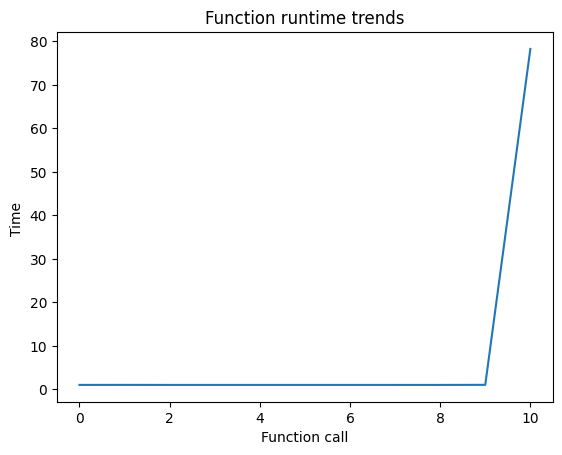

In [27]:
import time
predict_df = pd.read_csv('data/predict_sku1.csv')
date_range = pd.date_range(start='2019-01-01', end='2019-03-31', freq='D')
cols = ['sales_region_code', 'item_code', '2019年1月预测需求量', '2019年2月预测需求量', '2019年3月预测需求量']
predicted_demand_df = pd.DataFrame(columns=cols)
sales_region_code =     predict_df['sales_region_code']
item_code = predict_df['item_code']
    
for cc in code_columns:
    predict_df[cc] = predict_df[cc].astype('category')

predict_df = pd.get_dummies(predict_df, columns=code_columns,drop_first=True)
print("开始预测")
start_time = time.time()
for _, row in predict_df.iterrows():
    predict_data = row.to_frame().transpose()

#     region = int(predict_data['sales_region_code'])
    code = int(predict_data['item_code'])
    
    # 扩展日期列
    predict_data = pd.concat([predict_data]*len(date_range), ignore_index=True)
    predict_data['date'] = date_range
   
    # 提取特征
    predict_data['is_holiday'] = predict_data['date'].isin(holidays.China(years=2019))
    predict_data['year'] = predict_data['date'].dt.year
    predict_data['month'] = predict_data['date'].dt.month
    predict_data['weekday'] = predict_data['date'].dt.weekday
    predict_data['day'] = predict_data['date'].dt.day
    predict_data['week'] = predict_data['date'].dt.isocalendar().week.astype(int)
    predict_data["season"] = ((predict_data["date"].dt.month-1)//3+1)
    code_columns=['sales_region_code', 'first_cate_code', 'second_cate_code']
    predict_data.columns.drop('date')
    predict_data['month_sin'] = np.sin((predict_data['month'] - 1) * (2.0 * np.pi / 12))
    predict_data['month_cos'] = np.cos((predict_data['month'] - 1) * (2.0 * np.pi / 12))
    predict_data['season_sin'] = np.sin((predict_data['season'] - 1) * (2.0 * np.pi / 4))
    predict_data['season_cos'] = np.cos((predict_data['season'] - 1) * (2.0 * np.pi / 4))
    # 进行预测
    X_predict = predict_data[selected_features]
    y_predict = xgb.predict(X_predict)

    # 计算月总需求量
    predict_data['demand'] = y_predict
    monthly_demand = predict_data.groupby(['year', 'month'], as_index=False)['demand'].sum().astype(int)
    
    row = [1,code, 0, 0, 0]
    for _, row_month in monthly_demand.iterrows():
        month_col = '2019年{}月预测需求量'.format(int(row_month['month']))
        row[cols.index(month_col)] = row_month['demand']     
    predicted_demand_df.loc[len(predicted_demand_df)] = row
    print(predicted_demand_df)
    
end_time = time.time()


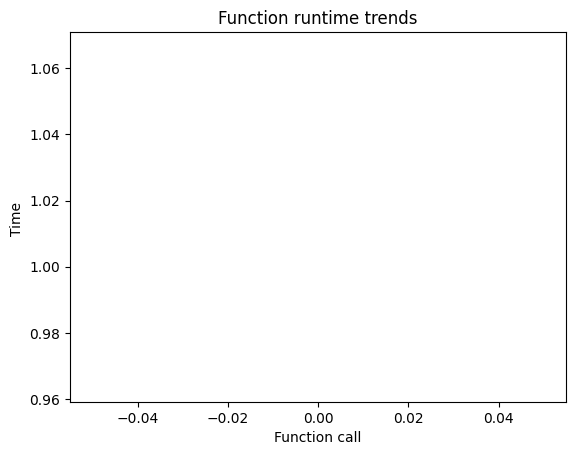

In [30]:
times=end_time - start_time
# 绘制时间趋势图
plt.plot(times)
plt.xlabel('Function call')
plt.ylabel('Time ')
plt.title('Function runtime trends')
plt.show()

In [24]:
#保存
predicted_demand_df ['sales_region_code'] = sales_region_code
predicted_demand_df.to_excel('data/result1.xlsx', index=False)


预测完成


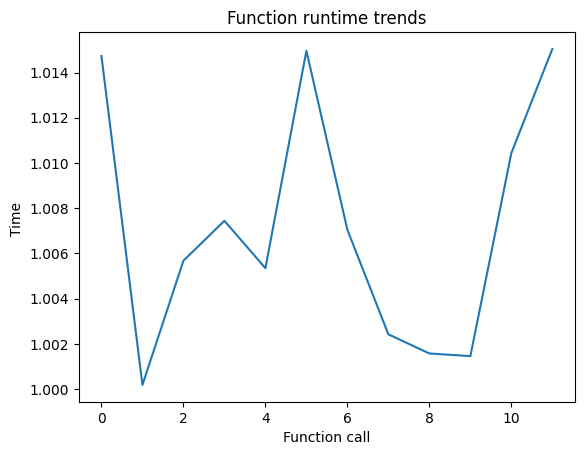

In [29]:
import time
def my_function():
    # 要执行的代码
    time.sleep(1)

# 记录函数运行时间
times = []
for i in range(12):
    start_time = time.time()
    my_function()
    end_time = time.time()
    times.append(end_time - start_time)

plt.plot(times)
plt.xlabel('Function call')
plt.ylabel('Time ')
plt.title('Function runtime trends')
plt.show()